In [1]:
import fitIR
import fitIR.models as models
import fitIR.analyse as analyse
from astropy.cosmology import WMAP9 as cosmo
import jax
import numpy as onp
import pylab as plt
import astropy.units as u
import scipy.integrate as integrate
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 
import matplotlib.pyplot as plt # visualization
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def generate_samples(size=100):
    #get parameter values from uniform distribution
    LIR=onp.random.uniform(low=8,high=15,size=size)
    redshift=onp.random.uniform(low=0.01,high=6,size=size)
    temperature=onp.random.uniform(low=10,high=70,size=size)
    #get standard deviation and mean for uniform dist
    LIR_sd=(15-8.0)/np.sqrt(12.0)
    LIR_mean=0.5*(15+8.0)
    
    red_sd=(6-0.01)/np.sqrt(12.0)
    red_mean=0.5*(0.01+6)
    
    temp_sd=(70.0-10.0)/np.sqrt(12.0)
    temp_mean=0.5*(70.0+10.0)
    return onp.vstack((LIR,redshift,temperature)).T,onp.vstack(((LIR-LIR_mean)/LIR_sd,(redshift-red_mean)/red_sd,(temperature-temp_mean)/temp_sd)).T

In [3]:
def transform_parameters(param):
    LIR_sd=(15.0-8)/np.sqrt(12.0)
    LIR_mean=0.5*(15+8.0)
    
    red_sd=(6-0.01)/np.sqrt(12.0)
    red_mean=0.5*(0.01+6)
    
    temp_sd=(70-10.0)/np.sqrt(12.0)
    temp_mean=0.5*(70+10.0)
    
    LIR_norm=(param[0]-LIR_mean)/LIR_sd
    red_norm=(param[1]-red_mean)/red_sd
    temp_norm=(param[2]-temp_mean)/temp_sd
    return np.vstack((LIR_norm,red_norm,temp_norm)).T

In [4]:
import xidplus
from xidplus import filters
filter_=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')
SPIRE_250=filter_.filters[215]
SPIRE_350=filter_.filters[216]
SPIRE_500=filter_.filters[217]
MIPS_24=filter_.filters[201]
PACS_100=filter_.filters[250]
PACS_160=filter_.filters[251]

bands=[SPIRE_250,SPIRE_350,SPIRE_500,MIPS_24,PACS_100,PACS_160]
eff_lam=[250.0,350.0,500.0,24.0, 100.0,160.0]

from scipy.interpolate import interp1d

def get_fluxes(samples):
    measured=onp.empty_like(samples)
    val = onp.linspace(onp.log10(3E8/8E-6),onp.log10(3E8/1E-3),1000)
    val = 10**val
    for i,s in enumerate(samples):
        z=s[1]
        prior = {}
        prior['z'] = s[1]
        prior['log10LIR'] = s[0]
        prior['T'] = s[2]
        prior['emissivity'] = 1.5



        source = models.greybody(prior)

        nu,lnu = source.generate_greybody(val,z)
        wave = 3E8/nu*1E6
        sed=interp1d(wave,lnu)
        dist = cosmo.luminosity_distance(z).to(u.cm).value

        for b in range(0,3):
            measured[i,b]=(1.0+z)*filters.fnu_filt(sed(bands[b].wavelength/1E4),
                                     3E8/(bands[b].wavelength/1E10),
                                     bands[b].transmission,
                                     3E8/(eff_lam[b]*1E-6),
                                     sed(eff_lam[b]))/(4*onp.pi*dist**2)
    return measured/10**(-26)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
W0106 11:49:16.412850 4433116608 logger.py:204] AstropyDeprecationWarning: block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
## class for sed using the torch dataset class
class sed_data(Dataset):
    
    def __init__(self,params,fluxes):
        self.X=params
        self.y=fluxes
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [6]:
batch_size=10
## generate random SED samples
samp_train,samp_stand_train=generate_samples(2000)
## Use Steve's code and xidplus filters to get fluxes
measured_train=get_fluxes(samp_train)
## use data in SED dataclass
ds = sed_data(samp_stand_train,measured_train)
## use torch DataLoader
train_loader = DataLoader(ds, batch_size=batch_size,)
## do same but for test set
samp_test,samp_stand_test=generate_samples(500)
measured_test=get_fluxes(samp_test)

ds = sed_data(samp_stand_test,measured_test)
test_loader = DataLoader(ds, batch_size=batch_size)

In [7]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(128), LeakyRelu,
    Dense(128), LeakyRelu,
    Dense(3)
)
in_shape = (-1, 3,)
out_shape, net_params = net_init(key,in_shape)

In [8]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

In [9]:
def sample_batch(outer_batch_size,inner_batch_size):
    def get_batch():
        xs, ys = [], []
        for i in range(0,outer_batch_size):
            samp_train,samp_stand_train=generate_samples(inner_batch_size)
            ## Use Steve's code and xidplus filters to get fluxes
            measured_train=get_fluxes(samp_train)
            xs.append(samp_stand_train)
            ys.append(np.log(measured_train))
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    return x1, y1

In [10]:
x,y=sample_batch(10,10)

(array([1., 6., 2., 1., 2., 1., 4., 6., 4., 3.]),
 array([-7.3337173, -5.7218084, -4.109899 , -2.4979901, -0.8860809,
         0.7258282,  2.3377373,  3.9496465,  5.5615554,  7.173465 ,
         8.785374 ], dtype=float32),
 <a list of 10 Patch objects>)

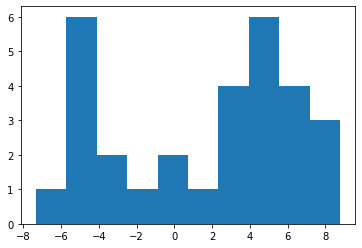

In [11]:
plt.hist(y[0,:].flatten())

In [24]:
opt_init, opt_update, get_params= optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(key,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp

np_batched_loss_1 = []
valid_loss=[]
K=40
for i in range(2000):
    x1_b, y1_b = sample_batch(10, K)
    x2_b,y2_b = sample_batch(1,K)
    opt_state, l = step(i, opt_state, x1_b, y1_b)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,x2_b,y2_b))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


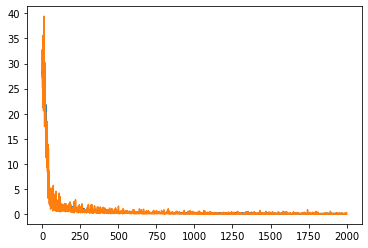

In [25]:
plt.plot(np_batched_loss_1)
plt.plot(valid_loss)

In [26]:
x,y=sample_batch(100,100)
predictions = net_apply(net_params,x)

In [27]:
res=predictions-y

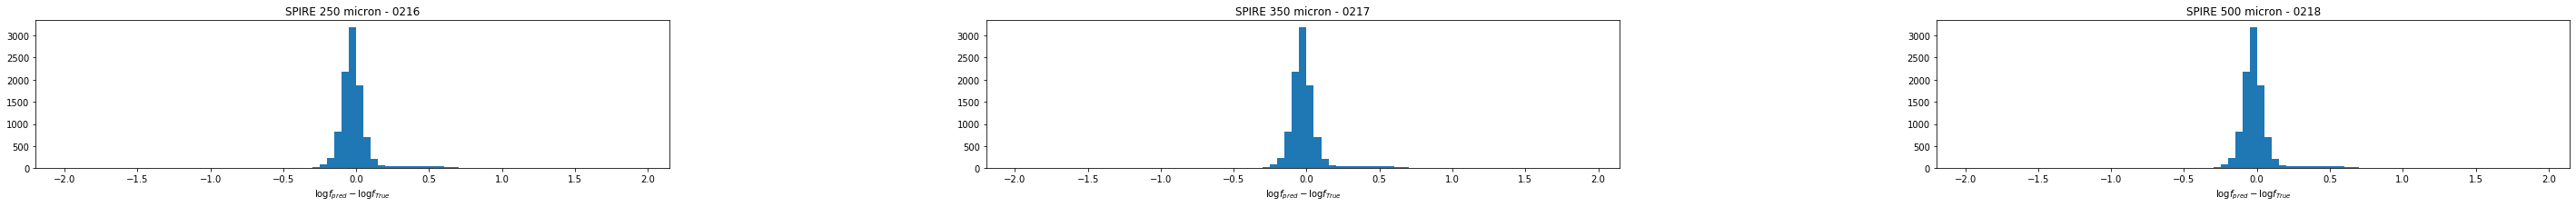

In [35]:
fig,axes=plt.subplots(1,3,figsize=(50,3))
for i in range(0,3):
    axes[i].hist(res[:,:,0].flatten(),np.arange(-2,2,0.05))
    axes[i].set_title(bands[i].name)
    axes[i].set_xlabel('$\log f_{pred} - \log f_{True}$')
plt.subplots_adjust(wspace=0.5)

In [148]:
net_apply(net_params,transform_parameters(np.array([10,2,70])))

DeviceArray([[-3.5368469, -4.215907 , -5.1577616]], dtype=float32)

In [29]:
samples=np.vstack((np.arange(8,15),0.1*np.ones((7)),60.0*np.ones((7))))
samples_norm=transform_parameters(samples)
pred=net_apply(net_params,samples_norm)
truth=onp.log(get_fluxes(samples.T))

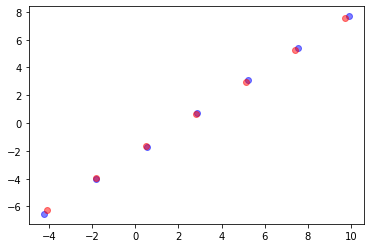

In [30]:
plt.plot(pred[:,0],pred[:,2],'bo',alpha=0.5)
plt.plot(truth[:,0],truth[:,2],'ro',alpha=0.5)

In [31]:
x2_b,y2_b = sample_batch(1,20)
p = get_params(opt_state)
pred=net_apply(p, x2_b)

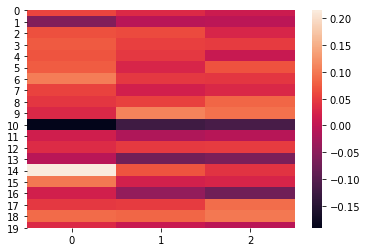

In [32]:
import seaborn as sns
sns.heatmap(y2_b[0,:,:]-pred[0,:,:])


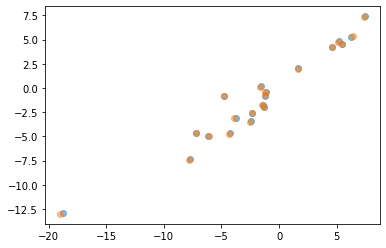

In [33]:
plt.plot(y2_b[0,:,0],y2_b[0,:,1],'o',alpha=0.5)
plt.plot(pred[0,:,0],pred[0,:,1],'o',alpha=0.5)

In [22]:
samples=np.vstack((np.arange(8,15),0.1*np.ones((7)),60.0*np.ones((7))))
samples_norm=transform_parameters(samples)
pred=net_apply(net_params,samples_norm[None,:,:])
truth=onp.log(get_fluxes(samples.T))[None,:,:]

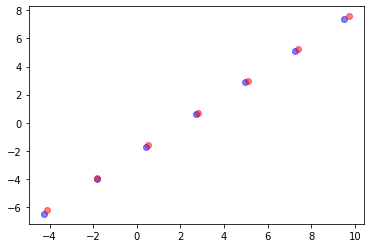

In [23]:
plt.plot(pred[0,:,0],pred[0,:,2],'bo',alpha=0.5)
plt.plot(truth[0,:,0],truth[0,:,2],'ro',alpha=0.5)

## Save network

In [41]:
import cloudpickle


In [47]:
with open('GB_emulator_20210106.pkl', 'wb') as f:
    cloudpickle.dump({'net_init':net_init,'net_apply': net_apply,'params':p,'transform_parameters':transform_parameters}, f)
    
net_init, net_apply

(<function jax.experimental.stax.serial.<locals>.init_fun(rng, input_shape)>,
 <function jax.experimental.stax.serial.<locals>.apply_fun(params, inputs, **kwargs)>)

In [43]:
with open('GB_emulator_20210106.pkl', "rb") as f:
    obj = pickle.load(f)

In [46]:
obj['net_apply'](p,samples_norm)

DeviceArray([[-4.2181034 , -5.3216076 , -6.5342913 ],
             [-1.8333745 , -2.9275086 , -4.04571   ],
             [ 0.5267367 , -0.58115715, -1.7066201 ],
             [ 2.8794906 ,  1.8520129 ,  0.698159  ],
             [ 5.244949  ,  4.218356  ,  3.1087701 ],
             [ 7.5368524 ,  6.478298  ,  5.381083  ],
             [ 9.879081  ,  8.794766  ,  7.6861196 ]], dtype=float32)